In [396]:
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [7]:
evictions_df = pd.read_csv("tracts.csv")
evictions_df = evictions_df.loc[evictions_df['year']==2010]
# evictions_df['GEOID'] = evictions_df['GEOID'].apply(lambda x: str(x))
evictions_df['GEOID'] = evictions_df.GEOID.apply(lambda x: int(x))
evictions_df.columns

Index(['GEOID', 'year', 'name', 'parent-location', 'population',
       'poverty-rate', 'renter-occupied-households', 'pct-renter-occupied',
       'median-gross-rent', 'median-household-income', 'median-property-value',
       'rent-burden', 'pct-white', 'pct-af-am', 'pct-hispanic', 'pct-am-ind',
       'pct-asian', 'pct-nh-pi', 'pct-multiple', 'pct-other',
       'eviction-filings', 'evictions', 'eviction-rate',
       'eviction-filing-rate', 'low-flag', 'imputed', 'subbed'],
      dtype='object')

In [8]:
df_headers = pd.read_csv("https://raw.githubusercontent.com/ireapps/census/master/tools/metadata/sf1_labels.csv")

In [9]:
# df_headers = pd.read_csv("https://raw.githubusercontent.com/ireapps/census/master/tools/metadata/sf1_labels.csv")
# main_df = pd.DataFrame()

# for header in tqdm(df_headers.table_code.unique()):
#     temp_df = pd.read_csv(f"http://censusdata.ire.org/39/all_140_in_39.{header}.csv")
#     temp_df = temp_df[temp_df.columns.drop(list(temp_df.filter(regex='2000')))]
#     cols_to_use = temp_df.columns.difference(main_df.columns)
#     if main_df.empty:
#         main_df = temp_df
#         continue
        
#     main_df = pd.merge(main_df, temp_df[list(cols_to_use)+['GEOID']], on='GEOID')
            
#     main_df.to_csv("census.csv")

100%|██████████████████████████████████████████████████████████████████████████████| 331/331 [1:03:22<00:00, 11.49s/it]


In [122]:
main_df = pd.read_csv("census.csv") 
main_df = main_df.drop("Unnamed: 0", axis=1)

In [54]:
rename_dict = {key: f"""{df_headers.loc[df_headers['col_code']==key].table_desc.item()} {df_headers.loc[df_headers['col_code']==key].table_universe.item()} {df_headers.loc[df_headers['col_code']==key].col_desc.item()}""" for key in main_df.columns[11:]}
main_df = main_df.rename(columns=rename_dict)

In [123]:
for col in tqdm(main_df.columns[11:]):
    parent = df_headers.loc[df_headers['col_code']==col].parent.item()
    if not pd.isnull(parent):
        parent_code = df_headers.loc[df_headers['col_code']==parent].col_code.item()
        try:
            main_df[f'{col}{parent_code}'] = main_df[col]/main_df[parent_code]
        except Exception as e:
            print(e)

 76%|██████████████████████████████████████████████████████████▋                  | 4426/5801 [00:20<00:06, 212.21it/s]

'PCT020002'
'PCT020002'
'PCT020002'
'PCT020001'


100%|█████████████████████████████████████████████████████████████████████████████| 5801/5801 [00:27<00:00, 211.18it/s]


In [467]:
main_df.to_csv("census.csv")

In [135]:
main_df = main_df.merge(evictions_df[['GEOID', 'eviction-rate']], on='GEOID')

In [230]:
corr_df = pd.DataFrame(columns=['col','r_value'])
y = main_df[main_df.columns[-1]]
for col in tqdm(main_df.columns[9:-1]):
    x = main_df[col]
    mask = ~np.isnan(x) & ~np.isnan(y)
    if len(x[mask]) == 0:
        continue
    slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
    corr_df = corr_df.append({'col':col, 'r_value':r_value}, ignore_index=True)
    
corr_df = corr_df.sort_values('r_value', ascending=False)

  7%|█████▌                                                                       | 829/11458 [00:03<00:39, 270.71it/s]c:\users\art perkitny\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
c:\users\art perkitny\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
 89%|██████████████████████████████████████████████████████████████████▍        | 10141/11458 [00:39<00:05, 241.63it/s]c:\users\art perkitny\anaconda3\lib\site-packages\numpy\lib\function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
 89%|███████████████████████████████████████████████████████████████████        | 10244/11458 [00:39<00:04, 249.26it/s]c:\users\art perkitny\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: i

In [341]:
corr_df.sort_values('r_value', ascending=True).head(10)

,col,r_value
9964,PCT016003PCT016002,-0.589446
10001,PCT017015PCT017014,-0.560314
11284,H018004H018003,-0.555499
11318,H018038H018037,-0.540434
10409,PCT021008PCT021005,-0.525947
10652,PCT022C009PCT022C008,-0.520625
9931,PCT015003PCT015002,-0.507814
10662,PCT022C019PCT022C018,-0.505329
10702,PCT022E019PCT022E018,-0.504569
10909,H014011H014010,-0.497801


In [233]:
df_headers.loc[df_headers['col_code'] == 'PCT021018']

,table_code,table_desc,table_universe,table_size,col_code,col_desc,indent,parent,has_children,col_code_2000
7813,PCT21,GROUP QUARTERS POPULATION BY SEX BY AGE BY GRO...,Population in group quarters,195,PCT021018,Mental (Psychiatric) hospitals and psychiatric...,5,PCT021017,False,NaN


In [232]:
corr_df.loc[corr_df['col']=='PCT021018PCT021017']

,col,r_value
10419,PCT021018PCT021017,0.997338


In [ ]:
for col in corr_df.sort_values('r_value', ascending=False).head(100).col:
    print(df_headers.loc[df_headers['col_code'] == col].table_desc.item(), df_headers.loc[df_headers['col_code'] == col].col_desc.item())

In [240]:
list(corr_df.sort_values('r_value', ascending=False).head(10).col)

['PCT021018PCT021017',
 'PCT021115PCT021114',
 'PCT022E021PCT022E018',
 'PCT016015PCT016002',
 'PCT017017PCT017014',
 'H018008H018003',
 'PCT022E011PCT022E008',
 'H018042H018037',
 'PCT022C011PCT022C008',
 'PCT019B005']

In [386]:
x_cols = [key for key, val in (main_df[list(corr_df.head(64).col)].isna().sum()<round(len(main_df)*0.1)).iteritems() if val]+['eviction-rate']
x_cols += [key for key, val in (main_df[list(corr_df.sort_values('r_value', ascending=True).head(64).col)].isna().sum()<round(len(main_df)*0.1)).iteritems() if val]

X = main_df[x_cols].dropna().drop('eviction-rate', axis=1)
y = main_df[x_cols].dropna()[['eviction-rate']]

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

(2909, 106) (2909, 1)


In [387]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.570623829149165, R2: 0.4677644204000636


In [388]:
model = SVR(kernel='rbf', C=3)
model.fit(X_train_scaled, y_train_scaled)

predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.5331847264371976, R2: 0.5026848382194824


In [436]:
predict_df = pd.DataFrame(columns=['predicted', 'actual', 'difference'])
for n in tqdm(range(len(X_test_scaled))):
    predicted = round(y_scaler.inverse_transform(model.predict([X_test_scaled[n]]))[0], 1)
    actual = round(y_scaler.inverse_transform(y_test_scaled[n])[0], 1)
    diff = round(predicted-actual,2)
#     print(predicted, actual, round(predicted-actual,2))
    predict_df = predict_df.append({'predicted':predicted, 'actual':actual, 'difference':diff}, ignore_index=True)

predict_df['percent'] = round(predict_df.difference/predict_df.actual*100)

100%|███████████████████████████████████████████████████████████████████████████████| 728/728 [00:01<00:00, 691.77it/s]


In [461]:
linregress(predict_df['actual'], predict_df['predicted'])

LinregressResult(slope=0.5149127601630112, intercept=1.3702326287710707, rvalue=0.7150137686177312, pvalue=5.71018227527002e-115, stderr=0.018685154094810613)

<AxesSubplot:xlabel='actual', ylabel='predicted'>

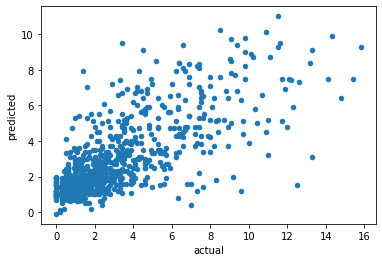

In [460]:
predict_df.plot(x='actual', y='predicted', kind='scatter')

<AxesSubplot:>

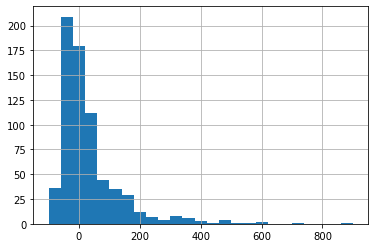

In [455]:
# predict_df.sort_values('percent')
predict_df.loc[np.isfinite(predict_df['percent'])].percent.hist(bins=25)

<AxesSubplot:>

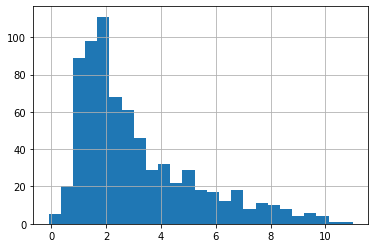

In [425]:
predict_df.predicted.hist(bins=25)

<AxesSubplot:>

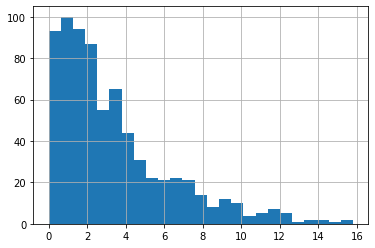

In [426]:
predict_df.actual.hist(bins=25)

In [465]:
predict_df.sort_values('actual', ascending=False)

,predicted,actual,difference,percent
682,9.3,15.8,-6.5,-41.0
11,7.5,15.4,-7.9,-51.0
137,6.4,14.8,-8.4,-57.0
500,9.9,14.3,-4.4,-31.0
638,7.5,14.1,-6.6,-47.0
718,9.1,13.3,-4.2,-32.0
330,3.1,13.3,-10.2,-77.0
445,8.4,13.2,-4.8,-36.0
9,7.3,12.6,-5.3,-42.0
191,1.5,12.5,-11.0,-88.0


In [385]:
R2 = 0.5026848382194824
for i in tqdm(range(25,75)):
    x_cols = [key for key, val in (main_df[list(corr_df.head(i).col)].isna().sum()<round(len(main_df)*0.25)).iteritems() if val]+['eviction-rate']
    x_cols += [key for key, val in (main_df[list(corr_df.sort_values('r_value', ascending=True).head(i).col)].isna().sum()<round(len(main_df)*0.1)).iteritems() if val]
    if len(x_cols)<=1:
        continue
        
    X = main_df[x_cols].dropna().drop('eviction-rate', axis=1)
    y = main_df[x_cols].dropna()[['eviction-rate']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)

    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    
#     model = LinearRegression()
#     model.fit(X_train_scaled, y_train_scaled)

#     predictions = model.predict(X_test_scaled)
#     MSE = mean_squared_error(y_test_scaled, predictions)
#     r2 = model.score(X_test_scaled, y_test_scaled)

#     model = Ridge(alpha=1.0)
#     model.fit(X_train_scaled, y_train_scaled)

#     predictions = model.predict(X_test_scaled)
#     MSE = mean_squared_error(y_test_scaled, predictions)
#     r2 = model.score(X_test_scaled, y_test_scaled)
    model = SVR(kernel='rbf', C=3)
    model.fit(X_train_scaled, y_train_scaled)

    predictions = model.predict(X_test_scaled)
    MSE = mean_squared_error(y_test_scaled, predictions)
    r2 = model.score(X_test_scaled, y_test_scaled)

#     model = RandomForestRegressor(n_estimators=10, random_state=42)
#     model.fit(X_train_scaled, y_train_scaled)

#     predictions = model.predict(X_test_scaled)
#     MSE = mean_squared_error(y_test_scaled, predictions)
#     r2 = model.score(X_test_scaled, y_test_scaled)

    if r2>=R2:
        print(f"i: {i}, MSE: {MSE}, R2: {r2}")
        R2 = r2

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:25<00:07,  1.25it/s]

i: 64, MSE: 0.5331847264371976, R2: 0.5026848382194824


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.49it/s]


- Try on another state, Indiana for example. What about a state with much different demographics such as New Mexico?
- Try on data from another year, how does the model handle when faced with newer data? 